In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

# Comparing Two Samples

In [5]:
births = Table.read_table('data/baby.csv')

In [6]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


This is an interesting and rich dataset. For today, we are only interested in two attributes/columns: 
- The birth weight of the child and
- whether or not the mother was smoking

Lets subset the dataset to only those two columns

In [7]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

Above, we saw that the dataset contains 1174 individuals/rows. Let's find out how many of the individuals were smokers and how many were not. What function would we use to quickly summarize the data?

In [8]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


Now let's visualize the weight distributions of the babies born to smoking mothers and those born to nonsmoking mothers. What chart would we use? Remember that we can specify the keyword argument `group` to overlay two distributions.

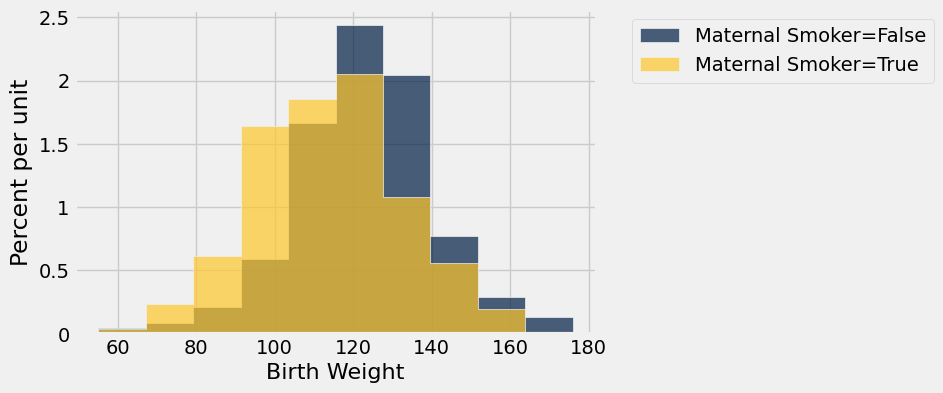

In [9]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

--- 
back to slides

---

# Test Statistic

**Questions**: 
- We have two samples (smoking, non-smoking). How do we summarize each sample into one number?
- Now we have two numbers. How do we combine those two numbers into a single number? (this is our statistic!)
- Should we use absolutes?
- Would large or small values for our statistic support our alternative?/ What values of our statistic are in favor of the alternative: positive or negative?

**Tasks:**
- Summarize samples
- Calculate the difference

In [10]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [11]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

**Tasks**
Write a function that 
- takes 
    - a table
    - the label of the numeric column
    - the label of the cateogry column
- computes the difference of the means
- returns the difference of the means

In [12]:
def difference_of_means(table, numeric_label, category_label):
    """
    Takes: 
       - name of table
       - column label of numerical variable
       - column label of categorical variable
       
    Returns: Difference of means of the two groups
    """
    
    #table with the two relevant columns
    reduced = table.select(numeric_label, category_label)  
    
    # table containing group means
    means_table = reduced.group(category_label, np.average)
    
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [13]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

---
back to slides

---
# Random Permutation (Shuffling)

In [36]:
staff = Table().with_columns(
    'Names', make_array('Jim', 'Pam', 'Dwight', 'Michael'),
    #'Ages', make_array(29, 28, 34, 41),
    'Manager', make_array(False, False, True, True).astype(bool),
)
staff

Names,Manager
Jim,False
Pam,False
Dwight,True
Michael,True


**Tasks** try out the different usages of `table.sample()`

In [37]:
staff.sample()

Names,Manager
Dwight,True
Dwight,True
Pam,False
Jim,False


In [38]:
staff.sample(with_replacement=False)

Names,Manager
Pam,False
Dwight,True
Michael,True
Jim,False


In [41]:
staff.with_column('Shuffled', staff.sample(with_replacement=False).column(1))

Names,Manager,Shuffled
Jim,False,True
Pam,False,False
Dwight,True,False
Michael,True,True


---
back to slides

---

# Simulation Under Null Hypothesis
**Tasks:**
- shuffle the table (w/o replacement), and pull out the labels
- attach the shuffled labels to the original table
- user our `difference_of_means()` function and calculate the difference of means using the original labels and then of the shuffled labels

In [18]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [19]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False).column('Maternal Smoker')

In [42]:
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)

In [43]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,True
True,108,True
False,136,False
False,138,False
False,132,False
False,120,False
True,143,True
False,140,False


In [22]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

-0.7129363011715952

In [23]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Permutation Test
Now we have a way to simulate under the null! All that is left is doing what we have been doing in hypothesis testing before:
- Write a function `one_simulated_difference()` that 
    - takes
        - a table
        - the label of the numerical attribute
        - the label of the categorical attribute
    - simulates one difference (of the means) under the null; i.e.
    - shuffle the labels and 
    - call `difference_of_means()` with the suffled labels
- call that function a bunch of times
- plot a histogram
- eyball where our observed statistic sits

In [45]:
def one_simulated_difference(table, numeric_label, category_label):
    """
    Takes: 
       - name of table
       - column label of numerical variable
       - column label of categorical variable
       
    Returns: Difference of means of the two groups
    """
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False).column(category_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.with_column('Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, numeric_label, 'Shuffled Label')   

In [48]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

0.5069061657297027

# Towards the conclusion
- call this function a bunch of times (e.g. 2500) and store the simulated differences of means in an array.
- make a histogram of those values
- eyeball where our observed statistic sits in the histogram

In [26]:
differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


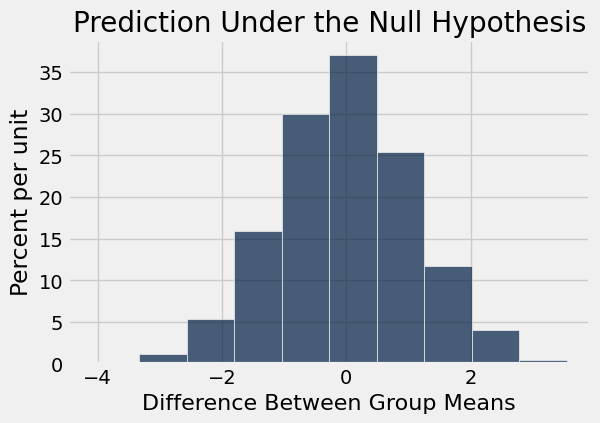

In [27]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

# P-Value
- Calculate the p-value

In [55]:
sum(differences < -9.3)

0

# Closing question
given the p-value (of 0), can we conclude that smoking **causes** lower birth rates?